In [1]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(stringr)
library(Sierra)
library(presto)
library(ggplot2)
library(msigdbr)
library(fgsea)
library(sctransform)
library(tidyverse)
setwd('/data1/APA/Shun_Lau/data/')

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
"replacing previous import 'GenomicRanges::union' by 'dplyr::union' when loading 'Sierra'"
Warning message:
"replacing previous import 'GenomicRanges::intersect' by 'dplyr::intersect' when loading 'Sierra'"
Warning message:
"replacing previous import 'GenomicRanges::setdiff' by 'dplyr::setdiff' when loading 'Sierra'"
Warning message:
"replacing previous import 'Gviz::tail' by 'utils::tail' when loading 'Sierra'"
Warning message:
"replacing previous import 'Gviz::head' by 'utils::head' when loading 'Sierra'"
Loading required package: Rcpp

Loading required package: data.table


Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


Registered S3 method overwritten by 'cli':
  method     f

In [15]:
samples_dir <- c('AD1', 'AD13','AD2','AD21','AD5','AD8','NC11','NC14',
                 'NC16','NC18','NC7','AD10','AD19','AD20','AD4','AD6',
                 'AD9','NC12','NC15','NC17','NC3')


In [34]:
all_samples_so <- list()
for (sample in samples_dir){
    log = paste0('reading bam files and creating the seurat object for sample: ',sample)
    print(log)
    data_dir = paste0(sample,'/outs/filtered_feature_bc_matrix/')
    expression_matrix <- Read10X(data.dir = data_dir)
    seurat_object = CreateSeuratObject(counts = expression_matrix)
    all_samples_so[[sample]] = seurat_object
}

[1] "reading bam files and creating the seurat object for sample: AD1"
[1] "reading bam files and creating the seurat object for sample: AD13"
[1] "reading bam files and creating the seurat object for sample: AD2"
[1] "reading bam files and creating the seurat object for sample: AD21"
[1] "reading bam files and creating the seurat object for sample: AD5"
[1] "reading bam files and creating the seurat object for sample: AD8"
[1] "reading bam files and creating the seurat object for sample: NC11"
[1] "reading bam files and creating the seurat object for sample: NC14"
[1] "reading bam files and creating the seurat object for sample: NC16"
[1] "reading bam files and creating the seurat object for sample: NC18"
[1] "reading bam files and creating the seurat object for sample: NC7"
[1] "reading bam files and creating the seurat object for sample: AD10"
[1] "reading bam files and creating the seurat object for sample: AD19"
[1] "reading bam files and creating the seurat object for sample: AD2

In [17]:
## a function to rename the cells
rename_barcodes <- function(so, sample_suffix){
    newnames <- gsub('-1', paste0('_', sample_suffix), Cells(so))
    so <- RenameCells(so, new.names = newnames)
    return(so)
}

In [20]:
for (sample in samples_dir){
    all_samples_so[[sample]] = rename_barcodes(all_samples_so[[sample]],
                                              sample)
}

An object of class Seurat 
36601 features across 5272 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

[1] "AAACGCTCATTAGGCT-1"

In [52]:
## process and qc the samples
qc_mito <- function(so){
    so[["percent.mt"]] <- PercentageFeatureSet(so, pattern = "^MT-")
    so <- tryCatch({
        so <- subset(so, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 10)
        },
        error=function(cond){
            return(NULL)
        }
                   )
                   
        
    return(so)
}

In [53]:
for (sample in samples_dir){
    log <- paste0('processing the sample: ', sample)
    print(log)
    all_samples_so[[sample]] = qc_mito(all_samples_so[[sample]])
}

[1] "processing the sample: AD1"
[1] "processing the sample: AD13"
[1] "processing the sample: AD2"
[1] "processing the sample: AD21"
[1] "processing the sample: AD5"
[1] "processing the sample: AD8"
[1] "processing the sample: NC11"
[1] "processing the sample: NC14"
[1] "processing the sample: NC16"
[1] "processing the sample: NC18"
[1] "processing the sample: NC7"
[1] "processing the sample: AD10"
[1] "processing the sample: AD19"
[1] "processing the sample: AD20"
[1] "processing the sample: AD4"
[1] "processing the sample: AD6"
[1] "processing the sample: AD9"
[1] "processing the sample: NC12"
[1] "processing the sample: NC15"
[1] "processing the sample: NC17"
[1] "processing the sample: NC3"


In [54]:
all_samples_so

$AD1
An object of class Seurat 
36601 features across 4157 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

$AD13
An object of class Seurat 
36601 features across 592 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

$AD2
An object of class Seurat 
36601 features across 10642 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

$AD21
An object of class Seurat 
36601 features across 3611 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

$AD5
An object of class Seurat 
36601 features across 8948 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

$AD8
An object of class Seurat 
36601 features across 673 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

$NC11
An object of class Seurat 
36601 features across 413 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

$NC14
An object of 

In [56]:
### integerate the samples and process the 
all_samples_so <- lapply(X = all_samples_so, FUN = SCTransform)
features <- SelectIntegrationFeatures(object.list = all_samples_so, nfeatures = 3000)
all_samples_so <- PrepSCTIntegration(object.list = all_samples_so, anchor.features = features)
all.anchors <- FindIntegrationAnchors(object.list = all_samples_so, normalization.method = "SCT",
    anchor.features = features)
ad_ct_combined <- IntegrateData(anchorset = all.anchors, normalization.method = "SCT")
ad_ct_combined <- RunPCA(ad_ct_combined, verbose = FALSE)
ad_ct_combined <- RunUMAP(ad_ct_combined, reduction = "pca", dims = 1:30)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 19535 by 4157

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 4157 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 63 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 19535 genes



  |======================================================================| 100%


Computing corrected count matrix for 19535 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.296152 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 13715 by 592

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 592 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |======================================================================| 100%


Found 60 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 13715 genes



  |======================================================================| 100%


Computing corrected count matrix for 13715 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 17.29136 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21867 by 10642

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 92 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 21867 genes



  |======================================================================| 100%


Computing corrected count matrix for 21867 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 3.272385 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 18326 by 3611

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3611 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 82 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 18326 genes



  |======================================================================| 100%


Computing corrected count matrix for 18326 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.338097 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 20547 by 8948

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 103 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 20547 genes



  |======================================================================| 100%


Computing corrected count matrix for 20547 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 3.052965 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 13288 by 673

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 673 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 94 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 13288 genes



  |======================================================================| 100%


Computing corrected count matrix for 13288 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 19.49036 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 11258 by 413

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 413 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"NaNs produced"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warnin

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |======================================================================| 100%


Found 123 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 11258 genes



  |======================================================================| 100%


Computing corrected count matrix for 11258 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 13.79935 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21102 by 7469

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 109 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 21102 genes



  |======================================================================| 100%


Computing corrected count matrix for 21102 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.916729 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 13745 by 1657

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 1657 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 97 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 13745 genes



  |======================================================================| 100%


Computing corrected count matrix for 13745 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 38.69432 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21773 by 9540

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 103 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 21773 genes



  |======================================================================| 100%


Computing corrected count matrix for 21773 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 3.084985 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 19102 by 4193

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 4193 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 95 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 19102 genes



  |======================================================================| 100%


Computing corrected count matrix for 19102 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.266443 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21285 by 10354

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 135 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 21285 genes



  |======================================================================| 100%


Computing corrected count matrix for 21285 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 3.115936 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 17725 by 1915

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 1915 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |======================================================================| 100%


Found 134 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 17725 genes



  |======================================================================| 100%


Computing corrected count matrix for 17725 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 45.01697 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 20491 by 6570

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 74 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 20491 genes



  |======================================================================| 100%


Computing corrected count matrix for 20491 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.791441 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 18419 by 3715

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3715 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 104 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 18419 genes



  |======================================================================| 100%


Computing corrected count matrix for 18419 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.37945 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 19414 by 5484

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 109 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 19414 genes



  |======================================================================| 100%


Computing corrected count matrix for 19414 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.695553 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 22288 by 12440

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 97 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 22288 genes



  |======================================================================| 100%


Computing corrected count matrix for 22288 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 3.36223 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 19780 by 5257

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 80 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 19780 genes



  |======================================================================| 100%


Computing corrected count matrix for 19780 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.745032 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21922 by 10925

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 101 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 21922 genes



  |======================================================================| 100%


Computing corrected count matrix for 21922 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 3.253287 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 19274 by 4307

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 4307 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 106 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 19274 genes



  |======================================================================| 100%


Computing corrected count matrix for 19274 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.350748 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2644 anchors

Filtering anchors

	Retained 2593 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 12209 anchors

Filtering anchors

	Retained 7125 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2738 anchors

Filtering anchors

	Retained 1258 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6873 anchors

Filtering anchors

	Retained 5358 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2640 anchors

Filtering anchors

	Retained 1841 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 9848 anchors

Fil

Finding anchors

	Found 17893 anchors

Filtering anchors

	Retained 8781 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3155 anchors

Filtering anchors

	Retained 1290 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1977 anchors

Filtering anchors

	Retained 693 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 16600 anchors

Filtering anchors

	Retained 9328 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6610 anchors

Filtering anchors

	Retained 2363 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 17115 anchors

Filtering anchors

	Retained 8666 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 11351 anchors

Filtering anchors

	Retained 6043 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5481 anchors

Filtering anchors

	R

Finding anchors

	Found 12602 anchors

Filtering anchors

	Retained 6613 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2758 anchors

Filtering anchors

	Retained 1076 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 21782 anchors

Filtering anchors

	Retained 10992 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 9584 anchors

Filtering anchors

	Retained 5142 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 19793 anchors

Filtering anchors

	Retained 8566 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3093 anchors

Filtering anchors

	Retained 1160 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1948 anchors

Filtering anchors

	Retained 656 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 15937 anchors

Filtering anchors

	

Finding anchors

	Found 8365 anchors

Filtering anchors

	Retained 6116 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 12007 anchors

Filtering anchors

	Retained 8931 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5881 anchors

Filtering anchors

	Retained 4378 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 10701 anchors

Filtering anchors

	Retained 8175 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 8048 anchors

Filtering anchors

	Retained 5366 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 9723 anchors

Filtering anchors

	Retained 7159 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 11937 anchors

Filtering anchors

	Retained 8729 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 9139 anchors

Filtering anchors

	R

In [57]:
ad_ct_combined

An object of class Seurat 
64063 features across 112862 samples within 3 assays 
Active assay: integrated (3000 features, 3000 variable features)
 2 other assays present: RNA, SCT
 2 dimensional reductions calculated: pca, umap

In [58]:
## now add some metadata

ad_ct_combined$cellnames <- Cells(ad_ct_combined)

In [80]:
samples <- sub(".*_(.*)", "\\1", ad_ct_combined$cellnames)
ad_ct_combined$samples <- samples
condition <- substr(samples, start = 1, stop = 2)
ad_ct_combined$condition <- condition

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



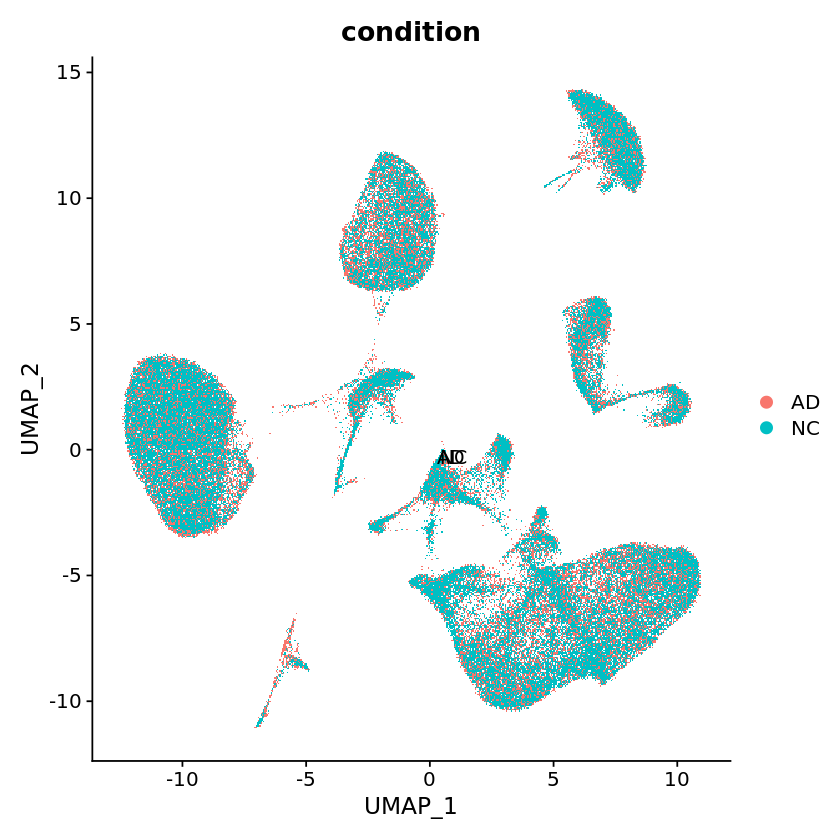

In [86]:
DimPlot(ad_ct_combined, reduction = 'umap', group.by = 'condition', label = T)

In [87]:
ref_ct_Dim <- readRDS('/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/rdata/Control_cell_types_GE_PFC.rds')
ref_ct_Dim

An object of class Seurat 
65217 features across 30147 samples within 1 assay 
Active assay: RNA (65217 features, 2000 variable features)
 3 dimensional reductions calculated: pca, umap, tsne

In [89]:
ref_ct_Dim <- SCTransform(ref_ct_Dim, verbose = T)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 33415 by 30147

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 52 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 33415 genes



  |======================================================================| 100%


Computing corrected count matrix for 33415 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 5.850594 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



In [90]:
query.anchors <- FindTransferAnchors(reference = ref_ct_Dim, query = ad_ct_combined,
    dims = 1:30, reference.reduction = "pca", normalization.method='SCT')
predictions <- TransferData(anchorset = query.anchors, refdata = ref_ct_Dim$main_cellTypes,
    dims = 1:30)
ad_ct_combined <- AddMetaData(ad_ct_combined, metadata = predictions)

Normalizing query using reference SCT model

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 5428 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



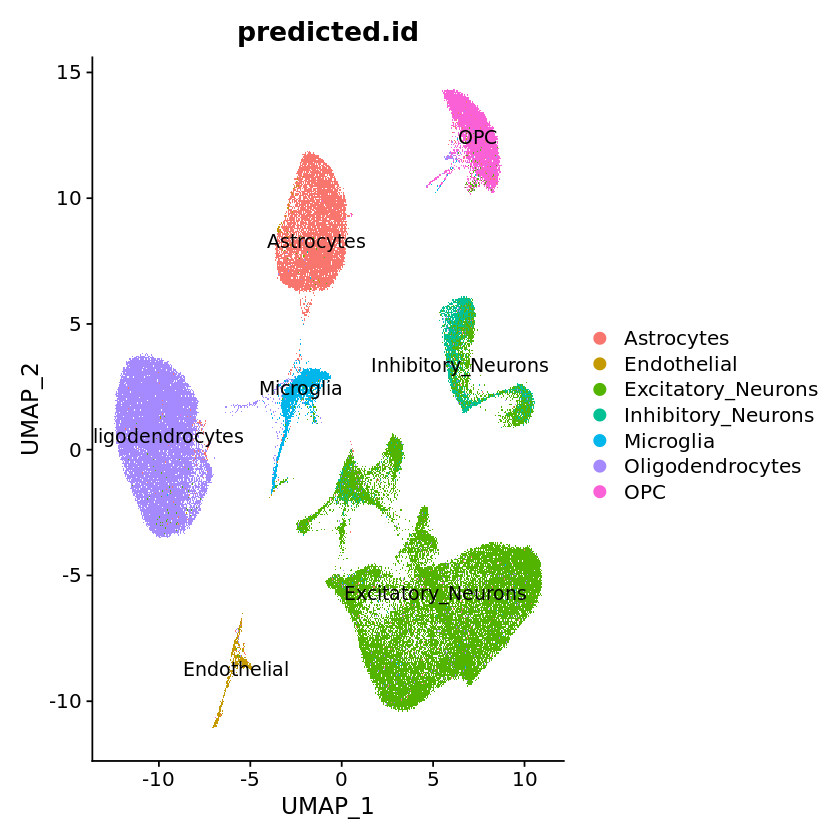

In [92]:
DimPlot(ad_ct_combined, reduction = 'umap', group.by = 'predicted.id', label = T)

In [93]:
ad_ct_combined$main_celltypes <- ad_ct_combined$predicted.id

In [99]:
query.anchors <- FindTransferAnchors(reference = ref_ct_Dim, query = ad_ct_combined,
    dims = 1:40, reference.reduction = "pca", normalization.method='SCT')
predictions <- TransferData(anchorset = query.anchors, refdata = ref_ct_Dim$cellType,
    dims = 1:40)
ad_ct_combined <- AddMetaData(ad_ct_combined, metadata = predictions)

Normalizing query using reference SCT model

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 5493 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [100]:
ad_ct_combined$subcelltypes <- ad_ct_combined$predicted.id

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



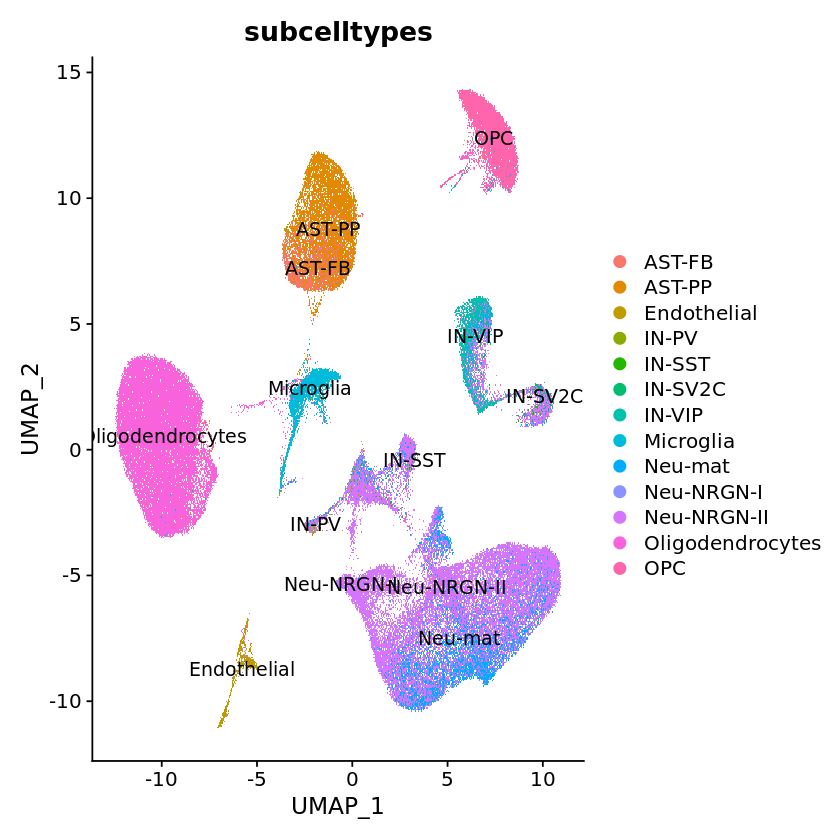

In [101]:
DimPlot(ad_ct_combined, reduction = 'umap', group.by = 'subcelltypes', label = T)

In [98]:
table(ref_ct_Dim$cellType)


          AST-FB           AST-PP      Endothelial            IN-PV 
            1106             1836              680             1123 
          IN-SST          IN-SV2C           IN-VIP             L2/3 
            1414              442             1357             3701 
              L4             L5/6          L5/6-CC        Microglia 
            2245              996             1253             1320 
         Neu-mat       Neu-NRGN-I      Neu-NRGN-II Oligodendrocytes 
             963              799             2066             5892 
             OPC 
            2954 

In [102]:
saveRDS(ad_ct_combined, file = 'rdata/ad_ct_ge_so.rds')

In [ ]:
saveRDS(ref_ct_Dim, file = '/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/rdata/Control_cell_types_GE_PFC_SCT.rds')

In [107]:
cell_sample_df <- data.frame(cells= ad_ct_combined$cellnames, sample=ad_ct_combined$samples)
cell_sample_df

cells                sample
AAACCCAAGCTGAAAT_AD1 AAACCCAAGCTGAAAT_AD1 AD1   
AAACCCACAAATGGTA_AD1 AAACCCACAAATGGTA_AD1 AD1   
AAACCCACAATGAAAC_AD1 AAACCCACAATGAAAC_AD1 AD1   
AAACCCAGTAGCGAGT_AD1 AAACCCAGTAGCGAGT_AD1 AD1   
AAACGAATCAACCGAT_AD1 AAACGAATCAACCGAT_AD1 AD1   
AAACGCTAGCGATGGT_AD1 AAACGCTAGCGATGGT_AD1 AD1   
AAACGCTAGCTGAAGC_AD1 AAACGCTAGCTGAAGC_AD1 AD1   
AAACGCTCATACGCAT_AD1 AAACGCTCATACGCAT_AD1 AD1   
AAACGCTCATTAGGCT_AD1 AAACGCTCATTAGGCT_AD1 AD1   
AAACGCTGTACGACTT_AD1 AAACGCTGTACGACTT_AD1 AD1   
AAACGCTGTGTTGATC_AD1 AAACGCTGTGTTGATC_AD1 AD1   
AAACGCTTCCGCGATG_AD1 AAACGCTTCCGCGATG_AD1 AD1   
AAAGAACAGAGCATAT_AD1 AAAGAACAGAGCATAT_AD1 AD1   
AAAGAACAGTATCCTG_AD1 AAAGAACAGTATCCTG_AD1 AD1   
AAAGAACGTGTGTTTG_AD1 AAAGAACGTGTGTTTG_AD1 AD1   
AAAGAACTCAAAGGTA_AD1 AAAGAACTCAAAGGTA_AD1 AD1   
AAAGGATGTGCTGTCG_AD1 AAAGGATGTGCTGTCG_AD1 AD1   
AAAGGATTCCGGACTG_AD1 AAAGGATTCCGGACTG_AD1 AD1   
AAAGGGCAGAACCCGA_AD1 AAAGGGCAGAACCCGA_AD1 AD1   
AAAGGGCAGGGACTGT_AD1 AAAGGGCAGGGACTGT_AD1 AD1   
AAAGGGCAGTGCAGCA_AD1 AAAGGGCAGTGCAGCA_AD1 AD1   
AAAGGGCCAAGACCTT_AD1 AAAGGGCCAAGACCTT_AD1 AD1   
AAAGGGCCACGTGAGA_AD1 AAAGGGCCACGTGAGA_AD1 AD1   
AAAGGGCCACTACGGC_AD1 AAAGGGCCACTACGGC_AD1 AD1   
AAAGGGCGTGTTATCG_AD1 AAAGGGCGTGTTATCG_AD1 AD1   
AAAGGGCTCGGCGATC_AD1 AAAGGGCTCGGCGATC_AD1 AD1   
AAAGGTAAGGGTACAC_AD1 AAAGGTAAGGGTACAC_AD1 AD1   
AAAGGTACACCTGCAG_AD1 AAAGGTACACCTGCAG_AD1 AD1   
AAAGGTAGTGACAGCA_AD1 AAAGGTAGTGACAGCA_AD1 AD1   
AAAGGTAGTTCGAACT_AD1 AAAGGTAGTTCGAACT_AD1 AD1   
⋮                    ⋮                    ⋮     
TTTCGATTCCGCATAA_NC3 TTTCGATTCCGCATAA_NC3 NC3   
TTTGACTCAGGATCTT_NC3 TTTGACTCAGGATCTT_NC3 NC3   
TTTGACTCATGGGAAC_NC3 TTTGACTCATGGGAAC_NC3 NC3   
TTTGACTGTAACTGCT_NC3 TTTGACTGTAACTGCT_NC3 NC3   
TTTGACTGTATACAGA_NC3 TTTGACTGTATACAGA_NC3 NC3   
TTTGATCAGAGCTGAC_NC3 TTTGATCAGAGCTGAC_NC3 NC3   
TTTGATCAGGCGCTCT_NC3 TTTGATCAGGCGCTCT_NC3 NC3   
TTTGATCAGTTAGTGA_NC3 TTTGATCAGTTAGTGA_NC3 NC3   
TTTGATCCACCTTCGT_NC3 TTTGATCCACCTTCGT_NC3 NC3   
TTTGATCCATCGTGGC_NC3 TTTGATCCATCGTGGC_NC3 NC3   
TTTGATCGTCTCAAGT_NC3 TTTGATCGTCTCAAGT_NC3 NC3   
TTTGATCGTGGTCTTA_NC3 TTTGATCGTGGTCTTA_NC3 NC3   
TTTGATCGTTGTGTAC_NC3 TTTGATCGTTGTGTAC_NC3 NC3   
TTTGATCTCTACGGTA_NC3 TTTGATCTCTACGGTA_NC3 NC3   
TTTGGAGAGAGCCGTA_NC3 TTTGGAGAGAGCCGTA_NC3 NC3   
TTTGGAGAGCCGATCC_NC3 TTTGGAGAGCCGATCC_NC3 NC3   
TTTGGAGTCACCGGTG_NC3 TTTGGAGTCACCGGTG_NC3 NC3   
TTTGGTTAGACTTCGT_NC3 TTTGGTTAGACTTCGT_NC3 NC3   
TTTGGTTCAATAGTCC_NC3 TTTGGTTCAATAGTCC_NC3 NC3   
TTTGGTTCACTACCGG_NC3 TTTGGTTCACTACCGG_NC3 NC3   
TTTGGTTCACTACGGC_NC3 TTTGGTTCACTACGGC_NC3 NC3   
TTTGGTTCACTGCATA_NC3 TTTGGTTCACTGCATA_NC3 NC3   
TTTGGTTCAGGGACTA_NC3 TTTGGTTCAGGGACTA_NC3 NC3   
TTTGGTTGTACCCACG_NC3 TTTGGTTGTACCCACG_NC3 NC3   
TTTGTTGAGGAAGAAC_NC3 TTTGTTGAGGAAGAAC_NC3 NC3   
TTTGTTGAGGGATCAC_NC3 TTTGTTGAGGGATCAC_NC3 NC3   
TTTGTTGCAAGATTGA_NC3 TTTGTTGCAAGATTGA_NC3 NC3   
TTTGTTGGTTCGGCCA_NC3 TTTGTTGGTTCGGCCA_NC3 NC3   
TTTGTTGTCACAATGC_NC3 TTTGTTGTCACAATGC_NC3 NC3   
TTTGTTGTCCAACTAG_NC3 TTTGTTGTCCAACTAG_NC3 NC3

In [108]:
cell_sample_df <- cell_sample_df %>% mutate(barcodes = paste0(sub("(.*)_.*","\\1",cells),'-1'))
cell_sample_df

cells                sample barcodes          
AAACCCAAGCTGAAAT_AD1 AAACCCAAGCTGAAAT_AD1 AD1    AAACCCAAGCTGAAAT-1
AAACCCACAAATGGTA_AD1 AAACCCACAAATGGTA_AD1 AD1    AAACCCACAAATGGTA-1
AAACCCACAATGAAAC_AD1 AAACCCACAATGAAAC_AD1 AD1    AAACCCACAATGAAAC-1
AAACCCAGTAGCGAGT_AD1 AAACCCAGTAGCGAGT_AD1 AD1    AAACCCAGTAGCGAGT-1
AAACGAATCAACCGAT_AD1 AAACGAATCAACCGAT_AD1 AD1    AAACGAATCAACCGAT-1
AAACGCTAGCGATGGT_AD1 AAACGCTAGCGATGGT_AD1 AD1    AAACGCTAGCGATGGT-1
AAACGCTAGCTGAAGC_AD1 AAACGCTAGCTGAAGC_AD1 AD1    AAACGCTAGCTGAAGC-1
AAACGCTCATACGCAT_AD1 AAACGCTCATACGCAT_AD1 AD1    AAACGCTCATACGCAT-1
AAACGCTCATTAGGCT_AD1 AAACGCTCATTAGGCT_AD1 AD1    AAACGCTCATTAGGCT-1
AAACGCTGTACGACTT_AD1 AAACGCTGTACGACTT_AD1 AD1    AAACGCTGTACGACTT-1
AAACGCTGTGTTGATC_AD1 AAACGCTGTGTTGATC_AD1 AD1    AAACGCTGTGTTGATC-1
AAACGCTTCCGCGATG_AD1 AAACGCTTCCGCGATG_AD1 AD1    AAACGCTTCCGCGATG-1
AAAGAACAGAGCATAT_AD1 AAAGAACAGAGCATAT_AD1 AD1    AAAGAACAGAGCATAT-1
AAAGAACAGTATCCTG_AD1 AAAGAACAGTATCCTG_AD1 AD1    AAAGAACAGTATCCTG-1
AAAGAACGTGTGTTTG_AD1 AAAGAACGTGTGTTTG_AD1 AD1    AAAGAACGTGTGTTTG-1
AAAGAACTCAAAGGTA_AD1 AAAGAACTCAAAGGTA_AD1 AD1    AAAGAACTCAAAGGTA-1
AAAGGATGTGCTGTCG_AD1 AAAGGATGTGCTGTCG_AD1 AD1    AAAGGATGTGCTGTCG-1
AAAGGATTCCGGACTG_AD1 AAAGGATTCCGGACTG_AD1 AD1    AAAGGATTCCGGACTG-1
AAAGGGCAGAACCCGA_AD1 AAAGGGCAGAACCCGA_AD1 AD1    AAAGGGCAGAACCCGA-1
AAAGGGCAGGGACTGT_AD1 AAAGGGCAGGGACTGT_AD1 AD1    AAAGGGCAGGGACTGT-1
AAAGGGCAGTGCAGCA_AD1 AAAGGGCAGTGCAGCA_AD1 AD1    AAAGGGCAGTGCAGCA-1
AAAGGGCCAAGACCTT_AD1 AAAGGGCCAAGACCTT_AD1 AD1    AAAGGGCCAAGACCTT-1
AAAGGGCCACGTGAGA_AD1 AAAGGGCCACGTGAGA_AD1 AD1    AAAGGGCCACGTGAGA-1
AAAGGGCCACTACGGC_AD1 AAAGGGCCACTACGGC_AD1 AD1    AAAGGGCCACTACGGC-1
AAAGGGCGTGTTATCG_AD1 AAAGGGCGTGTTATCG_AD1 AD1    AAAGGGCGTGTTATCG-1
AAAGGGCTCGGCGATC_AD1 AAAGGGCTCGGCGATC_AD1 AD1    AAAGGGCTCGGCGATC-1
AAAGGTAAGGGTACAC_AD1 AAAGGTAAGGGTACAC_AD1 AD1    AAAGGTAAGGGTACAC-1
AAAGGTACACCTGCAG_AD1 AAAGGTACACCTGCAG_AD1 AD1    AAAGGTACACCTGCAG-1
AAAGGTAGTGACAGCA_AD1 AAAGGTAGTGACAGCA_AD1 AD1    AAAGGTAGTGACAGCA-1
AAAGGTAGTTCGAACT_AD1 AAAGGTAGTTCGAACT_AD1 AD1    AAAGGTAGTTCGAACT-1
⋮                    ⋮                    ⋮      ⋮                 
TTTCGATTCCGCATAA_NC3 TTTCGATTCCGCATAA_NC3 NC3    TTTCGATTCCGCATAA-1
TTTGACTCAGGATCTT_NC3 TTTGACTCAGGATCTT_NC3 NC3    TTTGACTCAGGATCTT-1
TTTGACTCATGGGAAC_NC3 TTTGACTCATGGGAAC_NC3 NC3    TTTGACTCATGGGAAC-1
TTTGACTGTAACTGCT_NC3 TTTGACTGTAACTGCT_NC3 NC3    TTTGACTGTAACTGCT-1
TTTGACTGTATACAGA_NC3 TTTGACTGTATACAGA_NC3 NC3    TTTGACTGTATACAGA-1
TTTGATCAGAGCTGAC_NC3 TTTGATCAGAGCTGAC_NC3 NC3    TTTGATCAGAGCTGAC-1
TTTGATCAGGCGCTCT_NC3 TTTGATCAGGCGCTCT_NC3 NC3    TTTGATCAGGCGCTCT-1
TTTGATCAGTTAGTGA_NC3 TTTGATCAGTTAGTGA_NC3 NC3    TTTGATCAGTTAGTGA-1
TTTGATCCACCTTCGT_NC3 TTTGATCCACCTTCGT_NC3 NC3    TTTGATCCACCTTCGT-1
TTTGATCCATCGTGGC_NC3 TTTGATCCATCGTGGC_NC3 NC3    TTTGATCCATCGTGGC-1
TTTGATCGTCTCAAGT_NC3 TTTGATCGTCTCAAGT_NC3 NC3    TTTGATCGTCTCAAGT-1
TTTGATCGTGGTCTTA_NC3 TTTGATCGTGGTCTTA_NC3 NC3    TTTGATCGTGGTCTTA-1
TTTGATCGTTGTGTAC_NC3 TTTGATCGTTGTGTAC_NC3 NC3    TTTGATCGTTGTGTAC-1
TTTGATCTCTACGGTA_NC3 TTTGATCTCTACGGTA_NC3 NC3    TTTGATCTCTACGGTA-1
TTTGGAGAGAGCCGTA_NC3 TTTGGAGAGAGCCGTA_NC3 NC3    TTTGGAGAGAGCCGTA-1
TTTGGAGAGCCGATCC_NC3 TTTGGAGAGCCGATCC_NC3 NC3    TTTGGAGAGCCGATCC-1
TTTGGAGTCACCGGTG_NC3 TTTGGAGTCACCGGTG_NC3 NC3    TTTGGAGTCACCGGTG-1
TTTGGTTAGACTTCGT_NC3 TTTGGTTAGACTTCGT_NC3 NC3    TTTGGTTAGACTTCGT-1
TTTGGTTCAATAGTCC_NC3 TTTGGTTCAATAGTCC_NC3 NC3    TTTGGTTCAATAGTCC-1
TTTGGTTCACTACCGG_NC3 TTTGGTTCACTACCGG_NC3 NC3    TTTGGTTCACTACCGG-1
TTTGGTTCACTACGGC_NC3 TTTGGTTCACTACGGC_NC3 NC3    TTTGGTTCACTACGGC-1
TTTGGTTCACTGCATA_NC3 TTTGGTTCACTGCATA_NC3 NC3    TTTGGTTCACTGCATA-1
TTTGGTTCAGGGACTA_NC3 TTTGGTTCAGGGACTA_NC3 NC3    TTTGGTTCAGGGACTA-1
TTTGGTTGTACCCACG_NC3 TTTGGTTGTACCCACG_NC3 NC3    TTTGGTTGTACCCACG-1
TTTGTTGAGGAAGAAC_NC3 TTTGTTGAGGAAGAAC_NC3 NC3    TTTGTTGAGGAAGAAC-1
TTTGTTGAGGGATCAC_NC3 TTTGTTGAGGGATCAC_NC3 NC3    TTTGTTGAGGGATCAC-1
TTTGTTGCAAGATTGA_NC3 TTTGTTGCAAGATTGA_NC3 NC3    TTTGTTGCAAGATTGA-1
TTTGTTGGT

In [113]:
for (sample in unique(ad_ct_combined$samples)){
    tmp_df <- cell_sample_df[cell_sample_df$sample == sample,]
    outname <- paste0('bams_in/',sample,'_barcodes.tsv')
    write.table(tmp_df$barcodes, file=outname, quote=F, row.names=F, col.names=F)
}

In [115]:
outfile <- file("bams_in/subset_bamfiles.sh")
outlines = c()
for (sample in unique(ad_ct_combined$samples)){
    bc = paste0(sample,'_barcodes.tsv')
    bamfiles = paste0(' /data1/APA/Shun_Lau/data/raw_data/',sample,'/outs/possorted_genome_bam.bam')
    outname = paste0(" ",sample,'_filtered.bam')
    subset_arg = '~/softwares/subset_bam --bam '
    bc_arg = ' --cell-barcodes '
    out_arg = ' --out-bam'
    outline = paste0(subset_arg,bamfiles, bc_arg, bc, out_arg,outname, " &")
    print(outline)
    outlines <- append(outlines, outline)
}
writeLines(outlines, outfile)
close(outfile)

[1] "~/softwares/subset_bam --bam  /data1/APA/Shun_Lau/data/raw_data/AD1/outs/possorted_genome_bam.bam --cell-barcodes AD1_barcodes.tsv --out-bam AD1_filtered.bam &"
[1] "~/softwares/subset_bam --bam  /data1/APA/Shun_Lau/data/raw_data/AD13/outs/possorted_genome_bam.bam --cell-barcodes AD13_barcodes.tsv --out-bam AD13_filtered.bam &"
[1] "~/softwares/subset_bam --bam  /data1/APA/Shun_Lau/data/raw_data/AD2/outs/possorted_genome_bam.bam --cell-barcodes AD2_barcodes.tsv --out-bam AD2_filtered.bam &"
[1] "~/softwares/subset_bam --bam  /data1/APA/Shun_Lau/data/raw_data/AD21/outs/possorted_genome_bam.bam --cell-barcodes AD21_barcodes.tsv --out-bam AD21_filtered.bam &"
[1] "~/softwares/subset_bam --bam  /data1/APA/Shun_Lau/data/raw_data/AD5/outs/possorted_genome_bam.bam --cell-barcodes AD5_barcodes.tsv --out-bam AD5_filtered.bam &"
[1] "~/softwares/subset_bam --bam  /data1/APA/Shun_Lau/data/raw_data/AD8/outs/possorted_genome_bam.bam --cell-barcodes AD8_barcodes.tsv --out-bam AD8_filtered.bam &